# 使用PCA对人脸图片进行处理

此部分作业要求使用PCA技术对给定的人脸数据集进行处理，你需要在该文件中完成你的代码，并输出结果。



本次使用到的人脸数据集是 ORL人脸数据集，共包含40个不同人的400张图像。此数据集下包含40个目录，每个目录下有10张图像，每个目录表示一个不同的人。所有的图像是以PGM格式存储，灰度图，图像大小宽度为92，高度为112。



数据集中部分图像示例：

![image-20230428112024592](./faces.png)



在本次作业中，你需要**按顺序**完成以下内容并且在该文件中**保留要求**的输出结果：

1. 将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100，**输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度**。

2. 得到100个特征向量后，**使用这些向量重建特征脸并输出**。示例：

   ![image2](./feature.png)

3. 使用这100个特征和对应的特征向量，自行在训练集和测试集中**分别**选择**5张**人脸图片进行人脸重建并**输出对比图**。示例：

   ![image2](./restore.png)

4. **输出**降维后**每个**新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的**信息量总和**是原始数据的多少；

5. **画出**特征个数和所携带信息数的曲线图，此处特征数**上限设置为150**，此处以150为示例：

   ![image2](./information.png)

6.  保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数*n_neighbors*为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率。**注意：此处仅进行一次PCA**,输出：不同的特征保留数和准确率的曲线图。此处以*n_neighbors=5*为示例：

   ![image2](./acc.png)

   **本次作业严禁抄袭，一经发现严肃处理**


#  附加题

若感兴趣，可以自行拍摄自己或舍友的人脸照片、或者其他较为简单且特征明显的数据集进行PCA操作。


In [3]:
# 本次作业你可能需要用到的包和函数

%matplotlib inline
# 导入所需模块
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# 读取一个文件夹下的所有图片，输入参数是文件名，返回文件地址列表
def read_directory(directory_name):
    faces_addr = []
    for filename in os.listdir(directory_name):
        faces_addr.append(directory_name + "/" + filename)
    return faces_addr

压缩后的训练集维度: (320, 100), 压缩后的测试集维度: (80, 100), 特征向量维度: (100, 10304)


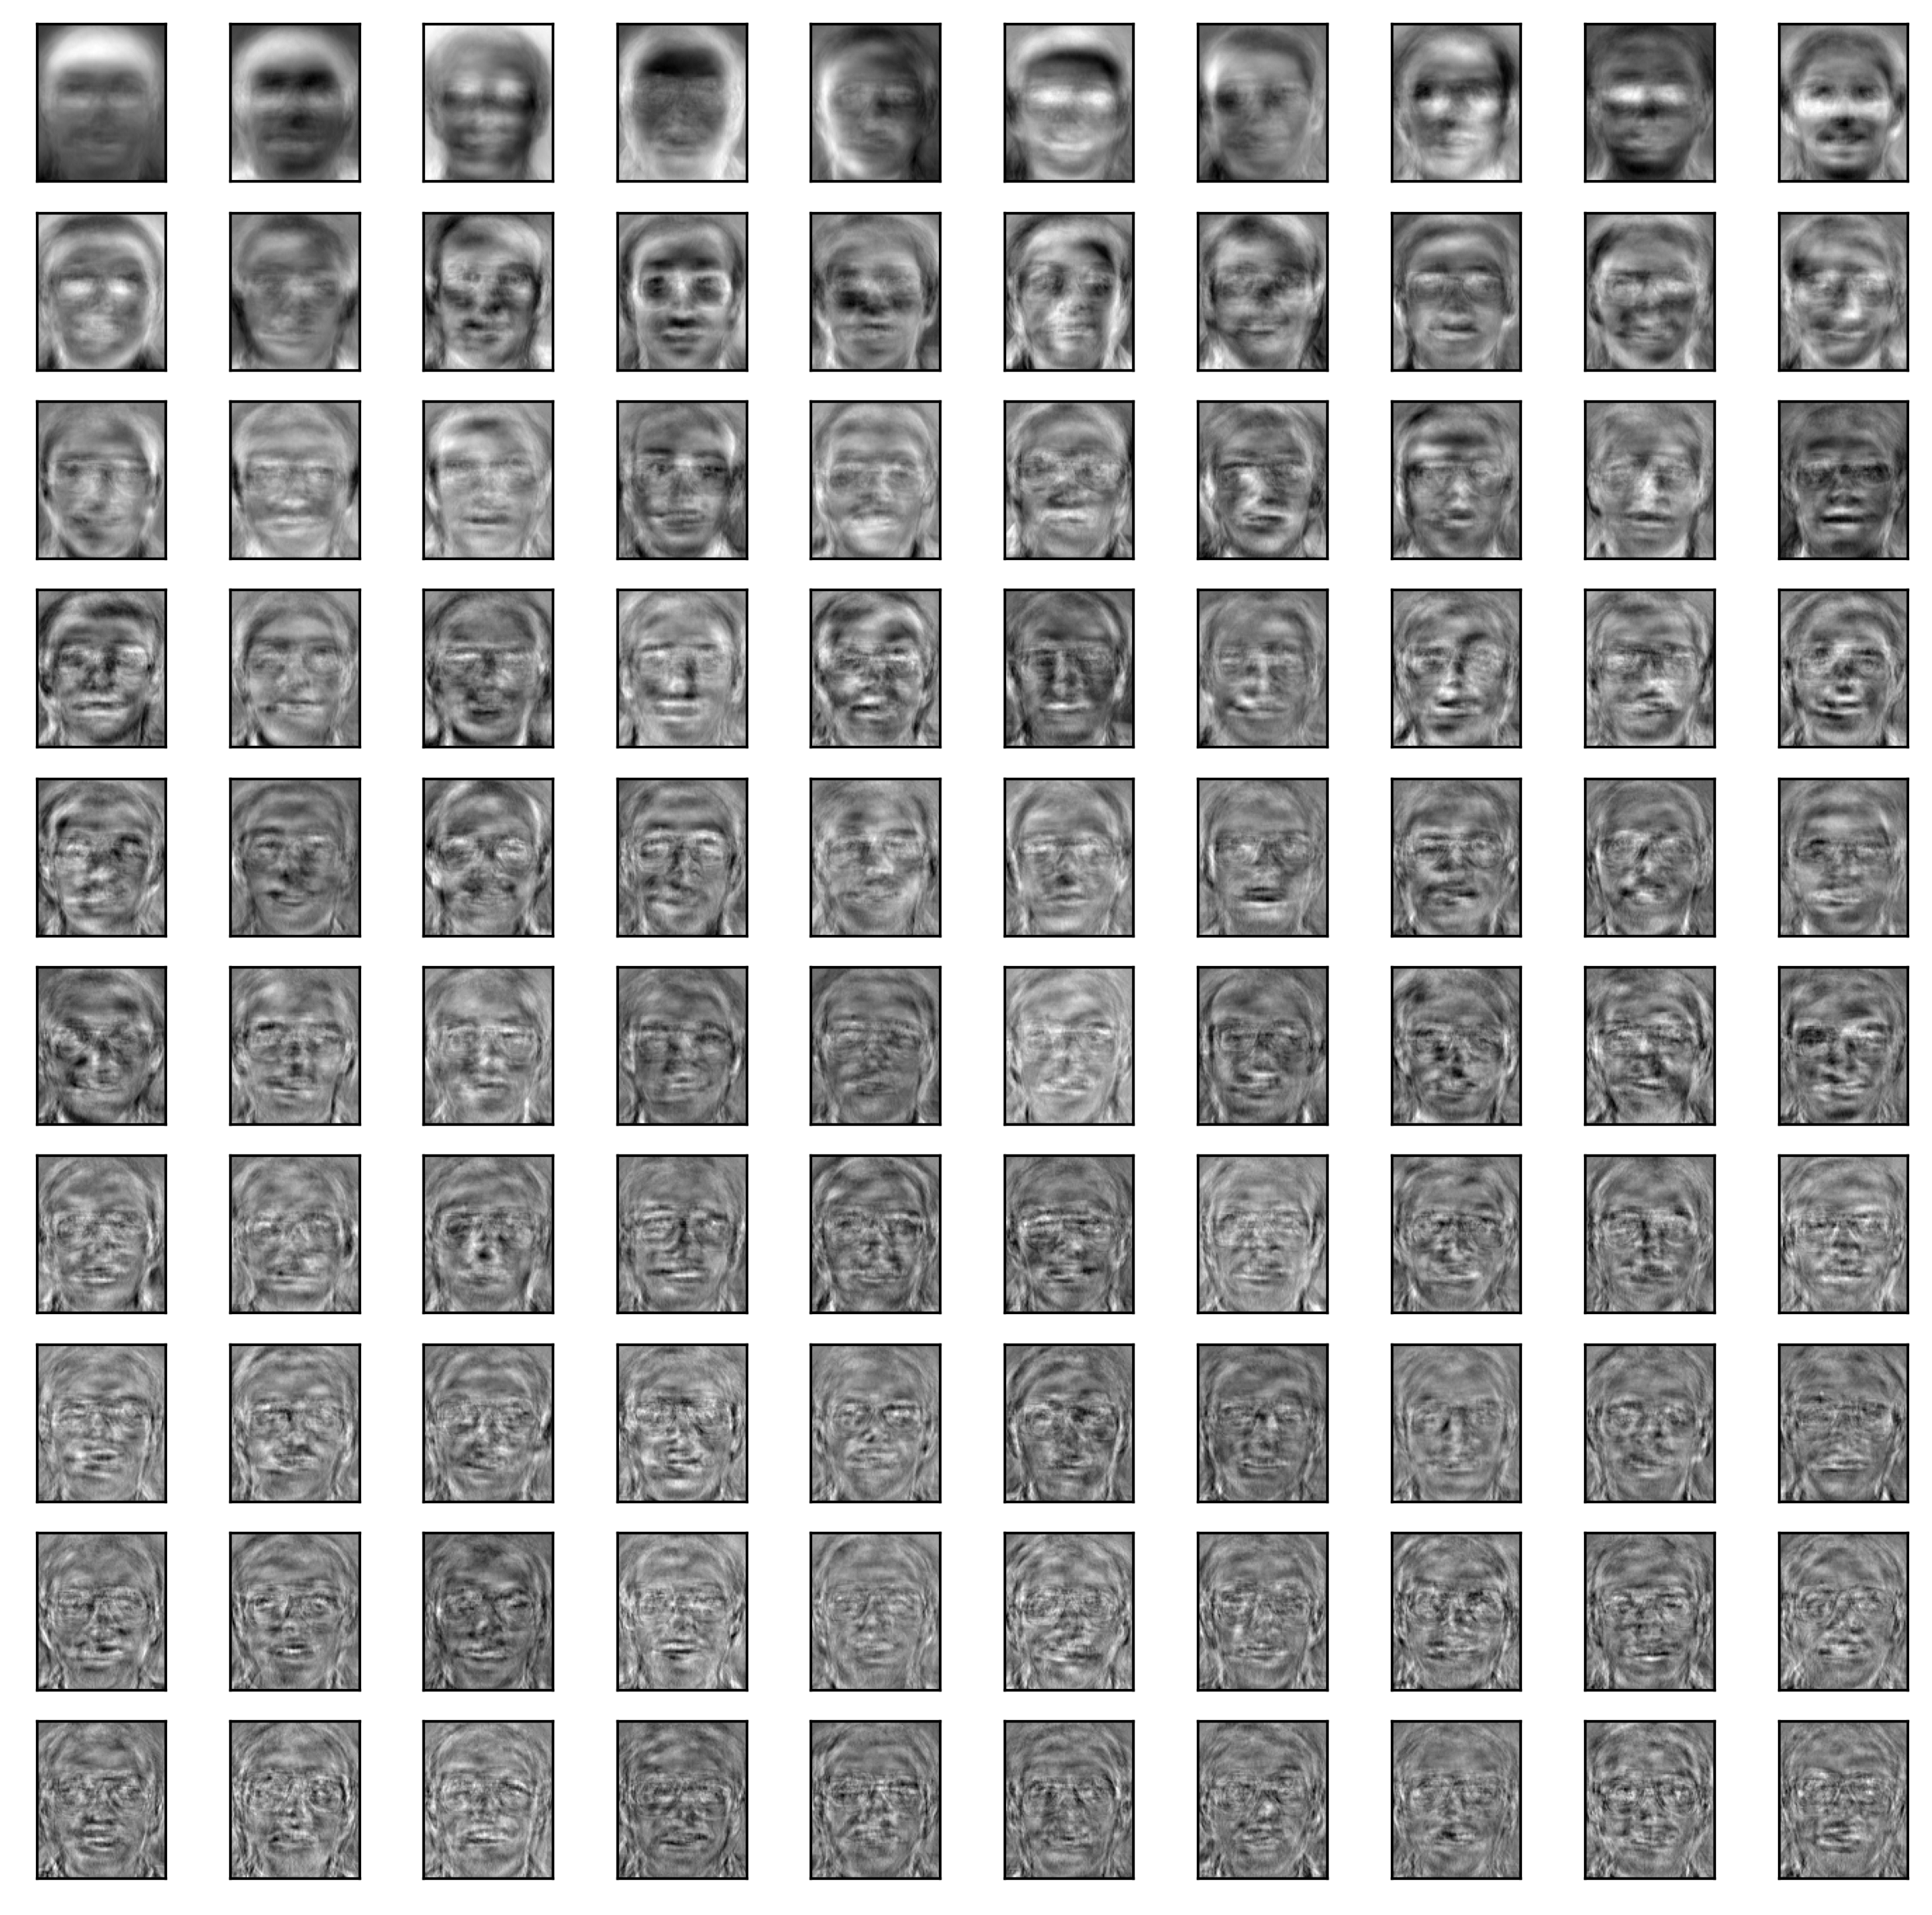

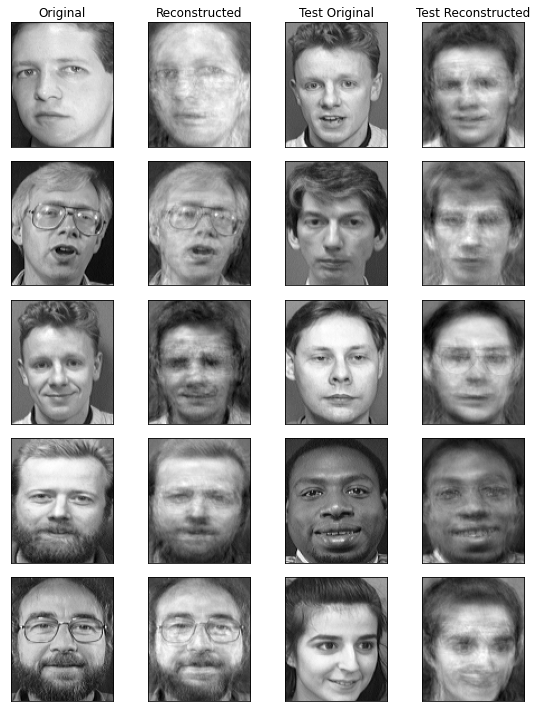

每个新特征向量所占信息量占原始数据总信息量的百分比: [17.69618504 12.71059271  6.8756048   5.52736199  5.13996154  3.487099
  2.49446072  2.20136693  1.88335869  1.83427122  1.48025439  1.36112136
  1.12551936  1.09960909  0.95855023  0.92974448  0.91364671  0.83460501
  0.76198979  0.71461731  0.69091628  0.63386618  0.59606946  0.57364237
  0.54146899  0.5340828   0.5070096   0.4798159   0.46401474  0.45021776
  0.43140241  0.41855623  0.40167824  0.39913153  0.37339407  0.36107412
  0.34810022  0.33948303  0.33088714  0.3136846   0.30153082  0.29397755
  0.29137056  0.28734615  0.27903541  0.27163923  0.26699424  0.25916072
  0.2531853   0.24904053  0.24671113  0.2385957   0.23213376  0.23068011
  0.2256377   0.21351009  0.21223829  0.20957866  0.20148931  0.19889278
  0.19715276  0.19160913  0.18437117  0.18278143  0.17344771  0.17213477
  0.17141833  0.16518287  0.16352949  0.16277427  0.16006173  0.15916061
  0.15608771  0.15030617  0.14987602  0.14763809  0.14545018  0.14490382
  0.14267852  0.14136694  

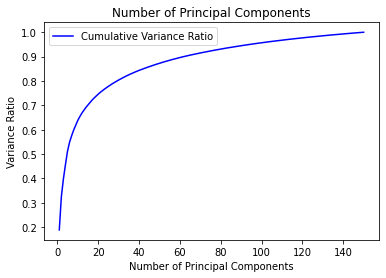

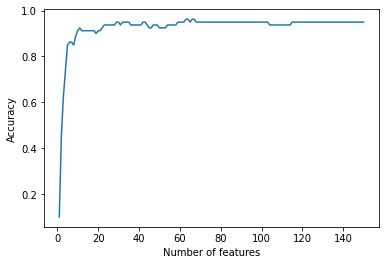

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage import io
from sklearn.neighbors import KNeighborsClassifier

# 1.将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100，**输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度**。
# 读取数据集
data_dir = './data'
image_size = (112, 92)  # 图片大小
data = []  # 保存所有图片数据
label = []  # 保存所有图片标签
for person_id in range(1, 41):
    person_dir = os.path.join(data_dir, f's{person_id}')
    for image_id in range(1, 11):
        image_path = os.path.join(person_dir, f'{image_id}.pgm')
        # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = io.imread(image_path, as_gray=True)
        data.append(img.flatten())
        label.append(person_id)


# 划分训练集和测试集
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)
# print('train_data.shape = {}'.format(np.array(train_data).shape))
# 对训练集进行PCA降维
pca = PCA(n_components=100)
train_data_pca = pca.fit_transform(train_data)
# print('train_data_pca.shape = {}'.format(train_data_pca.shape))
# 使用同样的PCA对测试集进行降维
test_data_pca = pca.transform(test_data)

# 输出压缩后的训练集和测试集的维度，以及PCA得到的特征向量维度
print(f"压缩后的训练集维度: {train_data_pca.shape}, 压缩后的测试集维度: {test_data_pca.shape}, 特征向量维度: {pca.components_.shape}")

# 2.得到100个特征向量后，**使用这些向量重建特征脸并输出**。
# mean_face = np.mean(train_data, axis=0)
feature_faces = []
for i in range(100):
    feature_vector = pca.components_[i]
    # print('mean_face.shape = {}'.format(mean_face.shape))
    # print('feature_vector.shape = {}'.format(feature_vector.shape))
    # print('pca.explained_variance_[i].shape = {}'.format(pca.explained_variance_[i].shape))
    # print('pca.transform(train_data).T.shape = {}'.format(pca.transform(train_data).T.shape))
    # feature_face = mean_face + np.dot(feature_vector, pca.explained_variance_[i] * pca.transform(train_data).T)
    # feature_face = np.reshape(feature_vector, (112, 92))
    feature_faces.append(feature_vector)

# 输出100个特征脸
fig, axes = plt.subplots(10, 10, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
fig.set_dpi(300)
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_faces[i].reshape(image_size), cmap='gray')
plt.show()

# 3.使用这100个特征和对应的特征向量，自行在训练集和测试集中**分别**选择**5张**人脸图片进行人脸重建并**输出对比图**。
# 选择5张训练集图片和测试集图片
train_indices = [0, 1, 2, 3, 4]
test_indices = [0, 1, 2, 3, 4]
train_images = train_data[0:5]
test_images = test_data[0:5]

# 在训练集上进行重建
reconstructed_train_images = pca.inverse_transform(train_data_pca[train_indices])

# 在测试集上进行重建
reconstructed_test_images = pca.inverse_transform(test_data_pca[test_indices])

# 输出对比图
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 10))

for i, ax in enumerate(axes):
    # 显示原始图片
    ax[0].imshow(train_images[i].reshape(image_size), cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    if i == 0:
        ax[0].set_title('Original')

    # 显示重建图片
    ax[1].imshow(reconstructed_train_images[i].reshape(image_size), cmap='gray')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    if i == 0:
        ax[1].set_title('Reconstructed')

    # 显示原始图片
    ax[2].imshow(test_images[i].reshape(image_size), cmap='gray')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    if i == 0:
        ax[2].set_title('Test Original')

    # 显示测试集重建图片
    ax[3].imshow(reconstructed_test_images[i].reshape(image_size), cmap='gray')
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    if i == 0:
        ax[3].set_title('Test Reconstructed')

plt.tight_layout()
plt.show()

# 4.**输出**降维后**每个**新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的**信息量总和**是原始数据的多少
# 计算每个新特征向量所占信息量占原始数据总信息量的百分比
info_percentages = pca.explained_variance_ratio_ * 100

# 计算所有特征向量的总信息量
total_info = sum(pca.explained_variance_ratio_)

# 输出每个新特征向量所占信息量占原始数据总信息量的百分比和所有特征向量的总信息量
print(f"每个新特征向量所占信息量占原始数据总信息量的百分比: {info_percentages}")
print(f"所有特征向量的总信息量: {total_info}")


# 5.**画出**特征个数和所携带信息数的曲线图，此处特征数**上限设置为150**
# 对训练数据进行PCA降维
pca = PCA(n_components=150)
train_data_pca = pca.fit_transform(train_data)

# 对测试数据进行PCA降维
test_data_pca = pca.transform(test_data)

# 计算特征值占比和特征值累加占比
eigenvalues = pca.explained_variance_
total_variance = np.sum(eigenvalues)
variance_ratio = eigenvalues / total_variance
# print('len(variance_ratio) = {}'.format(len(variance_ratio)))
cumulative_variance_ratio = np.cumsum(variance_ratio)

# 画出特征个数和所携带信息数的曲线图
plt.plot(range(1, 151), cumulative_variance_ratio[:150], 'b-', label='Cumulative Variance Ratio')
# plt.plot(range(1, 151), variance_ratio[:150], 'r-', label='Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Number of Principal Components')
plt.legend()
plt.show()

# 6.保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数*n_neighbors*为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率。**注意：此处仅进行一次PCA**,输出：不同的特征保留数和准确率的曲线图。
# 保留不同特征数时的准确率
accuracies = []
# 逐渐增加特征数，训练KNN分类器，并计算准确率
for n in range(1, 151):
    # 选取前n个特征
    train_data_pca_n = train_data_pca[:, :n]
    test_data_pca_n = test_data_pca[:, :n]
    
    # 训练KNN分类器
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_data_pca_n, train_label)
    
    # 在测试集上进行预测，并计算准确率
    accuracy = knn.score(test_data_pca_n, test_label)
    accuracies.append(accuracy)

# 画出特征数和准确率的曲线图
plt.plot(range(1, 151), accuracies)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.show()